In [1]:
import os
import collections
import numpy as np
import datetime
import tensorflow as tf
import tensorflow.contrib.slim as slim
from imblearn.under_sampling import RandomUnderSampler
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import warnings
warnings.filterwarnings('ignore', '.*output shape of zoom.*')

In [2]:
# Load npz
savepath = "/users/jmy/data/172_bbc.npz"
l = np.load(savepath)
bbc = l['bbc']
bbclabel = l['bbclabel']

savepath = "/users/jmy/data/172_dht.npz"
l = np.load(savepath)
dht = l['dht']
dhtlabel = l['dhtlabel']

In [2]:
savepath = "/users/jmy/data/172_val.npz"
l = np.load(savepath)
valimg = l['valimg']
vallabel = l['vallabel']

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [16]:
tf.reset_default_graph()

In [4]:
# inception v3 /from ggl09
n_input = 68403
n_classes = 191

x = tf.placeholder("float", [None,151,151,3])
y = tf.placeholder("float", [None, n_classes])
is_training = tf.placeholder(tf.bool)

def GoogLenet(inputs, is_training=True):
    with tf.device('/gpu:1'):
        x = inputs #tf.reshape(inputs, [-1, 139, 139, 3])
        batch_norm_params = {'is_training': is_training, 'decay': 0.9,
                             'updates_collections': None}
        init_func = tf.truncated_normal_initializer(stddev=0.01)
        with slim.arg_scope([slim.max_pool2d, slim.avg_pool2d],
                            stride=1, padding='VALID'):
            with slim.arg_scope([slim.conv2d], stride=1, padding='VALID',
                                activation_fn = tf.nn.relu,
                                weights_initializer = init_func,
                                normalizer_fn = slim.batch_norm,
                                normalizer_params = batch_norm_params):
                net = slim.conv2d(x, 32, [3, 3], stride=1,
                          activation_fn = tf.nn.relu, scope='conv_1a_3x3')
                net = slim.conv2d(net, 32, [3, 3], scope='conv_2a_3x3')
                net = slim.conv2d(net, 48, [3, 3], padding='SAME', scope='conv_2b_3x3')    
                net = slim.max_pool2d(net, [3, 3], stride=2, scope='MaxPool_3a_3x3')
                net = slim.conv2d(net, 64, [1, 1], scope='conv_3b_1x1') 
                net = slim.conv2d(net, 128, [3, 3], scope='conv_4a_3x3')
                net = slim.max_pool2d(net, [3, 3], stride=2, scope='MaxPool_5a_3x3')    
        # Inception blocks
        with slim.arg_scope([slim.max_pool2d, slim.avg_pool2d],
                        stride=1, padding='SAME'):
            with slim.arg_scope([slim.conv2d], stride=1, padding='SAME',
                            activation_fn = tf.nn.relu,
                            weights_initializer = init_func,
                            normalizer_fn = slim.batch_norm,
                            normalizer_params = batch_norm_params):
                with tf.variable_scope('Mixed_5b'):
                    with tf.variable_scope('Branch_0'):
                        branch_0 = slim.conv2d(net, 48, [1, 1], scope='Conv_0a_1x1')
                    with tf.variable_scope('Branch_1'): 
                        branch_1 = slim.conv2d(net, 32, [1, 1], scope='Conv_0a_1x1')
                        branch_1 = slim.conv2d(branch_1, 48, [5, 5], scope='Conv2d_0b_3x3')
                    with tf.variable_scope('Branch_2'):
                        branch_2 = slim.conv2d(net, 48, [1, 1], scope='Conv_0a_1x1')
                        branch_2 = slim.conv2d(branch_2, 64, [3, 3], scope='Conv_0b_3x3')
                        branch_2 = slim.conv2d(branch_2, 64, [3, 3], scope='Conv_0c_3x3')
                    with tf.variable_scope('Branch_3'):
                        branch_3 = slim.avg_pool2d(net, [3, 3], stride=1, scope='AvgPool_0a_3x3')
                        branch_3 = slim.conv2d(branch_3, 32, [1, 1], scope='Conv_0b_1x1')
                    net = tf.concat(axis=3, values=[branch_0, branch_1, branch_2, branch_3])

                with tf.variable_scope('Mixed_5c'):
                    with tf.variable_scope('Branch_0'):
                        branch_0 = slim.conv2d(net, 48, [1, 1], scope='Conv_0a_1x1')
                    with tf.variable_scope('Branch_1'): 
                        branch_1 = slim.conv2d(net, 32, [1, 1], scope='Conv_0a_1x1')
                        branch_1 = slim.conv2d(branch_1, 48, [5, 5], scope='Conv2d_0b_3x3')
                    with tf.variable_scope('Branch_2'):
                        branch_2 = slim.conv2d(net, 48, [1, 1], scope='Conv_0a_1x1')
                        branch_2 = slim.conv2d(branch_2, 64, [3, 3], scope='Conv_0b_3x3')
                        branch_2 = slim.conv2d(branch_2, 64, [3, 3], scope='Conv_0c_3x3')
                    with tf.variable_scope('Branch_3'):
                        branch_3 = slim.avg_pool2d(net, [3, 3], padding='SAME', scope='AvgPool_0a_3x3')
                        branch_3 = slim.conv2d(branch_3, 48, [1, 1], scope='Conv_0b_1x1')
                    net = tf.concat(axis=3, values=[branch_0, branch_1, branch_2, branch_3])        

                with tf.variable_scope('Mixed_5d'):
                    with tf.variable_scope('Branch_0'):
                        branch_0 = slim.conv2d(net, 48, [1, 1], scope='Conv_0a_1x1')
                    with tf.variable_scope('Branch_1'): 
                        branch_1 = slim.conv2d(net, 32, [1, 1], scope='Conv_0a_1x1')
                        branch_1 = slim.conv2d(branch_1, 48, [5, 5], scope='Conv2d_0b_3x3')
                    with tf.variable_scope('Branch_2'):
                        branch_2 = slim.conv2d(net, 48, [1, 1], scope='Conv_0a_1x1')
                        branch_2 = slim.conv2d(branch_2, 64, [3, 3], scope='Conv_0b_3x3')
                        branch_2 = slim.conv2d(branch_2, 64, [3, 3], scope='Conv_0c_3x3')
                    with tf.variable_scope('Branch_3'):
                        branch_3 = slim.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
                        branch_3 = slim.conv2d(branch_3, 48, [1, 1], scope='Conv_0b_1x1')
                    net = tf.concat(axis=3, values=[branch_0, branch_1, branch_2, branch_3])            
                # 15x15
                with tf.variable_scope('Mixed_6a'):
                    with tf.variable_scope('Branch_0'):
                        branch_0 = slim.conv2d(net, 192, [3, 3], padding='VALID',
                                           stride=2, scope='Conv_0a_1x1')
                    with tf.variable_scope('Branch_1'):
                        branch_1 = slim.conv2d(net, 48, [1, 1],
                                           scope='Conv_0a_1x1')
                        branch_1 = slim.conv2d(branch_1, 64, [3, 3],
                                           scope='Conv_0b_3x3')
                        branch_1 = slim.conv2d(branch_1, 64, [3, 3], stride=2,
                                           padding='VALID', scope='Conv_0c_3x3')
                    with tf.variable_scope('Branch_2'):
                        branch_2 = slim.max_pool2d(net, [3, 3], padding='VALID',
                                               stride=2, scope='MaxPool_1a_3x3')
                    net = tf.concat(axis=3, values=[branch_0, branch_1, branch_2])
                # 7x7    
                with tf.variable_scope('Mixed_6b'):
                    with tf.variable_scope('Branch_0'):
                        branch_0 = slim.conv2d(net, 128, [1, 1], scope='Conv_0a_1x1')
                    with tf.variable_scope('Branch_1'):
                        branch_1 = slim.conv2d(net, 96, [1, 1], scope='Conv_0a_1x1')
                        branch_1 = slim.conv2d(branch_1, 96, [1, 7], scope='Conv_0b_1x3')
                        branch_1 = slim.conv2d(branch_1, 128, [7, 1], scope='Conv_0c_3x1')
                    with tf.variable_scope('Branch_2'):
                        branch_2 = slim.conv2d(net, 96, [1, 1], scope='Conv_0a_1x1')
                        branch_2 = slim.conv2d(branch_2, 96, [7, 1], scope='Conv_0b_3x1')
                        branch_2 = slim.conv2d(branch_2, 96, [1, 7], scope='Conv_0c_1x3')
                        branch_2 = slim.conv2d(branch_2, 96, [7, 1], scope='Conv_0d_3x1')
                        branch_2 = slim.conv2d(branch_2, 160, [1, 7], scope='Conv_0e_1x3')
                    with tf.variable_scope('Branch_3'):    
                        branch_3 = slim.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
                        branch_3 = slim.conv2d(branch_3, 160, [1, 1], scope='Conv_0b_1x1')
                    net = tf.concat(axis=3, values=[branch_0, branch_1, branch_2, branch_3]) 

                with tf.variable_scope('Mixed_6c'):
                    with tf.variable_scope('Branch_0'):
                        branch_0 = slim.conv2d(net, 128, [1, 1], scope='Conv_0a_1x1')
                    with tf.variable_scope('Branch_1'):
                        branch_1 = slim.conv2d(net, 128, [1, 1], scope='Conv_0a_1x1')
                        branch_1 = slim.conv2d(branch_1, 128, [1, 7], scope='Conv_0b_1x3')
                        branch_1 = slim.conv2d(branch_1, 160, [7, 1], scope='Conv_0c_3x1')
                    with tf.variable_scope('Branch_2'):
                        branch_2 = slim.conv2d(net, 128, [1, 1], scope='Conv_0a_1x1')
                        branch_2 = slim.conv2d(branch_2, 128, [7, 1], scope='Conv_0b_3x1')
                        branch_2 = slim.conv2d(branch_2, 128, [1, 7], scope='Conv_0c_1x3')
                        branch_2 = slim.conv2d(branch_2, 128, [7, 1], scope='Conv_0d_3x1')
                        branch_2 = slim.conv2d(branch_2, 160, [1, 7], scope='Conv_0e_1x3')
                    with tf.variable_scope('Branch_3'):    
                        branch_3 = slim.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
                        branch_3 = slim.conv2d(branch_3, 160, [1, 1], scope='Conv_0b_1x1')
                    net = tf.concat(axis=3, values=[branch_0, branch_1, branch_2, branch_3])

                # Auxiliary classifier
                if is_training is not None:
                    with slim.arg_scope([slim.conv2d, slim.max_pool2d, slim.avg_pool2d],
                                        stride=1, padding='SAME'):
                        aux_logits = net
                        with tf.variable_scope('AuxLogits'):
                            aux_logits =slim.avg_pool2d(aux_logits, [5, 5], stride=3, padding='VALID',
                                scope='AvgPool_1a_3x3')
                            aux_logits = slim.conv2d(aux_logits, 96, [1, 1],
                                        normalizer_fn = slim.batch_norm,
                                        normalizer_params = batch_norm_params, scope='Conv_1b_1x1')
                            aux_logits = slim.conv2d(aux_logits, 512, [5, 5],
                                        normalizer_fn = slim.batch_norm,
                                        normalizer_params = batch_norm_params, weights_initializer=init_func,
                                        padding='VALID', scope='Conv_2a_3x3')#768
                            aux_logits = slim.conv2d(aux_logits, n_classes, [1, 1],
                                        normalizer_fn = slim.batch_norm,
                                        normalizer_params = batch_norm_params, activation_fn=None,
                                        weights_initializer=tf.truncated_normal_initializer(stddev=0.001),
                                        scope='Conv2d_2b_1x1')
                            aux_logits = tf.squeeze(aux_logits, [1, 2], name='SpatialSqueeze')

                with tf.variable_scope('Mixed_7a'):
                    with tf.variable_scope('Branch_0'):
                        branch_0 = slim.conv2d(net, 160, [1, 1], scope='Conv_0a_1x1')
                        branch_0 = slim.conv2d(branch_0, 192, [3, 3], stride=2,
                                               padding='VALID', scope='Conv_1a_1x1')
                    with tf.variable_scope('Branch_1'):
                        branch_1 = slim.conv2d(net, 160, [1, 1], scope='Conv_0a_1x1')
                        branch_1 = slim.conv2d(branch_1, 160, [1, 7], scope='Conv_0b_1x3')
                        branch_1 = slim.conv2d(branch_1, 160, [7, 1], scope='Conv_0c_3x1')
                        branch_1 = slim.conv2d(branch_1, 160, [3, 3], stride=2,
                                               padding='VALID', scope='Conv_1a_3x3')
                    with tf.variable_scope('Branch_2'):
                        branch_2 = slim.max_pool2d(net, [3, 3], stride=2,
                                               padding='VALID', scope='MaxPool_0a_3x3')
                    net = tf.concat(axis=3, values=[branch_0, branch_1, branch_2])        
                # 3x3
                with tf.variable_scope('Mixed_7b'):
                    with tf.variable_scope('Branch_0'):
                        branch_0 = slim.conv2d(net, 192, [1, 1], scope='Conv_0a_1x1')
                    with tf.variable_scope('Branch_1'):
                        branch_1 = slim.conv2d(net, 256, [1, 1], scope='Conv_0a_1x1')
                        branch_1 = tf.concat(axis=3, values=[
                            slim.conv2d(branch_1, 256, [1, 3], scope='Conv_0b_1x3'),
                            slim.conv2d(branch_1, 256, [3, 1], scope='Conv_0b_3x1')]) 
                    with tf.variable_scope('Branch_2'):
                        branch_2 = slim.conv2d(net, 256, [1, 1], scope='Conv_0a_1x1')#448
                        branch_2 = slim.conv2d(branch_2, 256, [3, 3], scope='Conv_0b_3x3')
                        branch_2 = tf.concat(axis=3, values=[
                            slim.conv2d(branch_2, 256, [1, 3], scope='Conv_0c_1x3'),
                            slim.conv2d(branch_2, 256, [3, 1], scope='Conv_0d_3x1')])
                    with tf.variable_scope('Branch_3'):                
                        branch_3 = slim.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
                        branch_3 = slim.conv2d(branch_3, 160, [1, 1], scope='Conv_0b_1x1')
                    net = tf.concat(axis=3, values=[branch_0, branch_1, branch_2, branch_3]) 

                with tf.variable_scope('Mixed_7c'):
                    with tf.variable_scope('Branch_0'):
                        branch_0 = slim.conv2d(net, 256, [1, 1], scope='Conv_0a_1x1')
                    with tf.variable_scope('Branch_1'):
                        branch_1 = slim.conv2d(net, 320, [1, 1], scope='Conv_0a_1x1')
                        branch_1 = tf.concat(axis=3, values=[
                            slim.conv2d(branch_1, 320, [1, 3], scope='Conv_0b_1x3'),
                            slim.conv2d(branch_1, 320, [3, 1], scope='Conv_0b_3x1')]) 
                    with tf.variable_scope('Branch_2'):
                        branch_2 = slim.conv2d(net, 320, [1, 1], scope='Conv_0a_1x1')#448
                        branch_2 = slim.conv2d(branch_2, 320, [3, 3], scope='Conv_0b_3x3')
                        branch_2 = tf.concat(axis=3, values=[
                            slim.conv2d(branch_2, 320, [1, 3], scope='Conv_0c_1x3'),
                            slim.conv2d(branch_2, 320, [3, 1], scope='Conv_0d_3x1')])
                    with tf.variable_scope('Branch_3'):                
                        branch_3 = slim.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
                        branch_3 = slim.conv2d(branch_3, 160, [1, 1], scope='Conv_0b_1x1')
                    net = tf.concat(axis=3, values=[branch_0, branch_1, branch_2, branch_3])            
            # avg pool
            net = slim.avg_pool2d(net, [8, 8], stride=1, padding='VALID', scope='AvgPool_1a_3x3') 
            net = slim.dropout(net, keep_prob=0.8, is_training=is_training, scope='dr1')
            out = slim.conv2d(net, n_classes, [1, 1], activation_fn=None,
                                     normalizer_fn=None, scope='Conv_1c_1x1')
            # spatial squeeze
            out = tf.squeeze(out, name='SpatialSqueeze')
    return aux_logits, out

In [7]:
# without decay
# Prediction
aux, pred = GoogLenet(x, is_training)

# Loss & Optimizer
cost1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        labels=y, logits=pred)) # real
cost2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        labels=y, logits=aux)) # aux
cost = cost1 + 0.4 * cost2

optm = tf.train.AdamOptimizer(0.01, epsilon=0.1).minimize(cost)
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accr = tf.reduce_mean(tf.cast(corr, "float"))

with tf.name_scope('performance'):
    loss_ph = tf.placeholder('float', shape=None, name='loss_summary')
    loss_summ = tf.summary.scalar('loss', loss_ph)
    accr_ph = tf.placeholder('float', shape=None, name='accr_summary')
    accr_summ = tf.summary.scalar('accr', accr_ph)

merged = tf.summary.merge_all()

# Initializer
init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(init)
train_writer = tf.summary.FileWriter("./board/ggl28_train", sess.graph)
val_writer = tf.summary.FileWriter("./board/ggl28_val")
print ("FUNCTIONS READY")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.
FUNCTIONS READY


In [ ]:
# with l_r decay
# Prediction
aux, pred = GoogLenet(x, is_training)

# Loss & Optimizer
cost1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        labels=y, logits=pred)) # real
cost2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        labels=y, logits=aux)) # aux
cost = cost1 + 0.4 * cost2

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.045 
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           42527, 0.96, staircase=True)
# 8 epoch 쯤 decay
optm = tf.train.RMSPropOptimizer(learning_rate, epsilon=1.0).minimize(cost, global_step=global_step)
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accr = tf.reduce_mean(tf.cast(corr, "float"))

with tf.name_scope('performance'):
    loss_ph = tf.placeholder('float', shape=None, name='loss_summary')
    loss_summ = tf.summary.scalar('loss', loss_ph)
    accr_ph = tf.placeholder('float', shape=None, name='accr_summary')
    accr_summ = tf.summary.scalar('accr', accr_ph)

merged = tf.summary.merge_all()

# Initializer
init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(init)
train_writer = tf.summary.FileWriter("./board/ggl28_train", sess.graph)
val_writer = tf.summary.FileWriter("./board/ggl28_val")
print ("FUNCTIONS READY")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.cast instead.
FUNCTIONS READY


In [5]:
print(pred)

[<tf.Tensor 'AuxLogits/SpatialSqueeze:0' shape=(?, 191) dtype=float32>, <tf.Tensor 'SpatialSqueeze:0' shape=<unknown> dtype=float32>]


In [5]:
c0 = iaa.CropToFixedSize(width=151, height=151, position='left-top')
c1 = iaa.CropToFixedSize(width=151, height=151, position='center-top')
c2 = iaa.CropToFixedSize(width=151, height=151, position='right-top')
c3 = iaa.CropToFixedSize(width=151, height=151, position='left-center')
c4 = iaa.CropToFixedSize(width=151, height=151, position='center')
c5 = iaa.CropToFixedSize(width=151, height=151, position='right-center')
c6 = iaa.CropToFixedSize(width=151, height=151, position='left-bottom')
c7 = iaa.CropToFixedSize(width=151, height=151, position='center-bottom')
c8 = iaa.CropToFixedSize(width=151, height=151, position='right-bottom')
c9 = iaa.Sequential([c0,iaa.Fliplr(1.0)])
c10 = iaa.Sequential([c1,iaa.Fliplr(1.0)])
c11 = iaa.Sequential([c2,iaa.Fliplr(1.0)])
c12 = iaa.Sequential([c3,iaa.Fliplr(1.0)])
c13 = iaa.Sequential([c4,iaa.Fliplr(1.0)])
c14 = iaa.Sequential([c5,iaa.Fliplr(1.0)])
c15 = iaa.Sequential([c6,iaa.Fliplr(1.0)])
c16 = iaa.Sequential([c7,iaa.Fliplr(1.0)])
c17 = iaa.Sequential([c8,iaa.Fliplr(1.0)])

aug = iaa.OneOf([c0, c1, c2, c3, c4, c5, c6, c7, c8, c9,
                 c10, c11, c12, c13, c14, c15, c16, c17])

aug_val = iaa.OneOf([c0, c2, c4, c6, c8])

def fancy_pca(img, alpha_std=0.1):
    orig_img = img.copy()
    img_rs = img.reshape(-1,3)
    img_centered = img_rs - np.mean(img_rs, axis=0)
    img_cov = np.cov(img_centered, rowvar=False)
    eig_vals, eig_vecs = np.linalg.eigh(img_cov)
    sort_perm = eig_vals[::-1].argsort()
    eig_vals[::-1].sort()
    eig_vecs = eig_vecs[:, sort_perm]
    m1 = np.column_stack((eig_vecs))
    m2 = np.zeros((3, 1))
    alpha = np.random.normal(0, alpha_std)
    m2[:, 0] = alpha * eig_vals[:]
    add_vect = np.matrix(m1) * np.matrix(m2)
    for idx in range(3):   # RGB
        orig_img[..., idx] += add_vect[idx]
    orig_img = np.clip(orig_img, 0.0, 1.0)
    return orig_img

def augment_img(xs):
    xs_r = np.reshape(xs, [-1, 172, 172, 3])
    out = np.array(aug.augment_images(xs_r))
    for i in range(xs_r.shape[0]):
        xs_img = out[i, :, :, :] 
        xs_img = fancy_pca(xs_img)
        out[i,:,:,:] = xs_img
    return out

def augment_valimg(xs):
    xs_r = np.reshape(xs, [-1, 172, 172, 3])
    out = np.array(aug_val.augment_images(xs_r))
    return out

In [ ]:
savedir = "/users/jmy/data/nets/191_class/ggl28/"
saver = tf.train.Saver(max_to_keep=100)
save_step = 5
if not os.path.exists(savedir):
    os.makedirs(savedir)

In [10]:
s_0 = {}
for i in range(64):
    s_0[i]=475

In [11]:
# Parameters
training_epochs = 300
batch_size = 32 # 아마 64? / inception v3는 100epoch 32
display_step = 1
#miss_step = 1
val_acc = 0.
ntrain = 90725 # /191 = 475
nval = valimg.shape[0]
batch_val = 32 # 128도 가능 메모리 bbb ???

# Optimize
for epoch in range(training_epochs):
    print(datetime.datetime.now().time())
    avg_cost = 0.
    total_batch = int(ntrain/batch_size)
    rus = RandomUnderSampler(random_state=epoch, sampling_strategy=s_0)
    X_0, d = rus.fit_resample(bbc, bbclabel)
    y_0 = bbclabel[rus.sample_indices_,:]
    rus = RandomUnderSampler(random_state=epoch)
    X_1, d = rus.fit_resample(dht, dhtlabel)
    y_1 = dhtlabel[rus.sample_indices_,:]
    X_res = np.concatenate((X_0,X_1), axis=0)
    y_res = np.concatenate((y_0,y_1), axis=0)
    randpermlist = np.random.permutation(ntrain)
    # Iteration
    for i in range(total_batch):
        randidx = randpermlist[i*batch_size:min((i+1)*batch_size, ntrain-1)]
        batch_xs = X_res[randidx, :]
        batch_ys = y_res[randidx, :]
        # Augmentaion
        batch_xs = augment_img(batch_xs)
        feeds = {x: batch_xs, y: batch_ys, is_training:True}
        sess.run(optm, feed_dict=feeds)
        avg_cost += sess.run(cost, feed_dict=feeds)
    avg_cost = avg_cost / total_batch
    # Display
    if epoch == 0 or (epoch+1) % display_step == 0:
        print("Epoch : %03d/%03d cost: %.9f" % (epoch+1, training_epochs, avg_cost))
        feeds = {x: batch_xs, y: batch_ys, is_training:False}
        train_acc = sess.run(accr, feed_dict=feeds)
        print("Train accuracy: %.5f" % (train_acc))
        randpermlist = np.random.permutation(nval)
        randidx = randpermlist[:batch_val]
        batch_vx = valimg[randidx, :]
        batch_vx = augment_valimg(batch_vx)
        batch_vy = vallabel[randidx, :]
        feeds = {x: batch_vx, y: batch_vy, is_training:False}
        val_acc = sess.run(accr, feed_dict=feeds)
        val_loss = sess.run(cost1, feed_dict=feeds)
        print("Validation accuracy: %.5f cost: %.9f \n" % (val_acc, val_loss)) 
        summ = sess.run(merged, feed_dict={loss_ph:val_loss, accr_ph:val_acc})
        val_writer.add_summary(summ, epoch)
        summ = sess.run(merged, feed_dict={loss_ph:avg_cost, accr_ph:train_acc})
        train_writer.add_summary(summ, epoch)
    # Save
    if (epoch+1) % save_step == 0:
        savename = savedir + "net-" + str(epoch) + ".cpkt"
        saver.save(sess=sess, save_path=savename)
        print("[%s] Saved" % (savename))  
print("Optimization finished")

07:36:22.867377
Epoch : 001/300 cost: 6.252689871
Train accuracy: 0.06250
Validation accuracy: 0.09375 cost: 3.930800438 

08:07:29.557415
Epoch : 002/300 cost: 4.931179213
Train accuracy: 0.31250
Validation accuracy: 0.31250 cost: 2.537662506 

08:38:03.438684
Epoch : 003/300 cost: 4.152706890
Train accuracy: 0.31250
Validation accuracy: 0.28125 cost: 2.894243240 

09:08:26.046165
Epoch : 004/300 cost: 3.583017265
Train accuracy: 0.40625
Validation accuracy: 0.53125 cost: 1.997130513 

09:38:58.595651
Epoch : 005/300 cost: 3.195197625
Train accuracy: 0.25000
Validation accuracy: 0.53125 cost: 1.571769714 

[/users/jmy/data/nets/191_class/ggl28/net-4.cpkt] Saved
10:09:21.629375
Epoch : 006/300 cost: 2.915191828
Train accuracy: 0.50000
Validation accuracy: 0.56250 cost: 1.776667476 

10:39:47.394774
Epoch : 007/300 cost: 2.703353320
Train accuracy: 0.68750
Validation accuracy: 0.53125 cost: 1.622776031 

11:10:07.424554
Epoch : 008/300 cost: 2.543368498
Train accuracy: 0.59375
Validatio

Epoch : 062/300 cost: 0.936871420
Train accuracy: 0.96875
Validation accuracy: 0.75000 cost: 1.006762624 

06:18:15.014519
Epoch : 063/300 cost: 0.931674840
Train accuracy: 0.93750
Validation accuracy: 0.65625 cost: 1.413108230 

07:29:07.011845
Epoch : 064/300 cost: 0.925400958
Train accuracy: 0.87500
Validation accuracy: 0.81250 cost: 0.695201755 

08:48:44.295985
Epoch : 065/300 cost: 0.910936803
Train accuracy: 0.96875
Validation accuracy: 0.87500 cost: 0.484809458 

[/users/jmy/data/nets/191_class/ggl28/net-64.cpkt] Saved
10:05:28.748162
Epoch : 066/300 cost: 0.910723942
Train accuracy: 0.84375
Validation accuracy: 0.75000 cost: 1.121327877 

11:16:02.123842
Epoch : 067/300 cost: 0.893929313
Train accuracy: 0.90625
Validation accuracy: 0.78125 cost: 0.513577104 

12:27:40.714767
Epoch : 068/300 cost: 0.885348696
Train accuracy: 0.93750
Validation accuracy: 0.78125 cost: 0.998751521 

13:40:43.734044
Epoch : 069/300 cost: 0.877872608
Train accuracy: 0.93750
Validation accuracy: 0.9

Epoch : 124/300 cost: 0.638765669
Train accuracy: 0.96875
Validation accuracy: 0.78125 cost: 1.350564122 

06:45:24.080026
Epoch : 125/300 cost: 0.637043316
Train accuracy: 1.00000
Validation accuracy: 0.75000 cost: 1.475047112 

[/users/jmy/data/nets/191_class/ggl28/net-124.cpkt] Saved
07:23:27.703545
Epoch : 126/300 cost: 0.632747703
Train accuracy: 0.96875
Validation accuracy: 0.75000 cost: 0.941614270 

08:05:07.601204
Epoch : 127/300 cost: 0.632148112
Train accuracy: 0.96875
Validation accuracy: 0.81250 cost: 1.023607612 

08:47:42.797063
Epoch : 128/300 cost: 0.634552325
Train accuracy: 1.00000
Validation accuracy: 0.75000 cost: 1.538190722 

09:28:48.837300
Epoch : 129/300 cost: 0.627685711
Train accuracy: 0.96875
Validation accuracy: 0.87500 cost: 0.454399884 

10:10:53.581129
Epoch : 130/300 cost: 0.627059486
Train accuracy: 1.00000
Validation accuracy: 0.84375 cost: 1.120581269 

[/users/jmy/data/nets/191_class/ggl28/net-129.cpkt] Saved
10:52:03.468855
Epoch : 131/300 cost: 0

KeyboardInterrupt: 

In [6]:
aux, pred = GoogLenet(x, is_training)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        labels=y, logits=pred))
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accr = tf.reduce_mean(tf.cast(corr, "float"))

# Initializer
init = tf.global_variables_initializer()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(init)
print ("FUNCTIONS READY")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

FUNCTIONS READY


In [7]:
savedir = "/users/jmy/data/nets/191_class/ggl28/"
saver = tf.train.Saver(max_to_keep=100)

In [13]:
valimg.shape

(3183, 88752)

In [9]:
best_epoch = 134
batch_val = 796 
nval = valimg.shape[0]
avg_acc = 0.
restorename = savedir + "net-" + str(best_epoch) + ".cpkt"
print("Loading [%s]" % (restorename))
saver.restore(sess, restorename)
for i in range(4):
    batch_vx = valimg[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vy = vallabel[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vx = augment_valimg(batch_vx)
    feeds = {x: batch_vx, y: batch_vy, is_training:False}    
    val_acc = sess.run(accr, feed_dict=feeds)
    val_loss = sess.run(cost, feed_dict=feeds)
    avg_acc += val_acc
    print("val accuracy: %.5f cost %.9f" % (val_acc, val_loss))
avg_acc = avg_acc / 4.
print("\n avg acc : %.5f" % (avg_acc))

Loading [/users/jmy/data/nets/191_class/ggl28/net-134.cpkt]
INFO:tensorflow:Restoring parameters from /users/jmy/data/nets/191_class/ggl28/net-134.cpkt
val accuracy: 0.91457 cost 0.358919621
val accuracy: 0.78894 cost 1.118644953
val accuracy: 0.76508 cost 1.221613646
val accuracy: 0.75945 cost 1.188814402

 avg acc : 0.80701


In [14]:
best_epoch = 119
batch_val = 796 
nval = valimg.shape[0]
avg_acc = 0.
restorename = savedir + "net-" + str(best_epoch) + ".cpkt"
print("Loading [%s]" % (restorename))
saver.restore(sess, restorename)
for i in range(4):
    batch_vx = valimg[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vy = vallabel[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vx = augment_valimg(batch_vx)
    feeds = {x: batch_vx, y: batch_vy, is_training:False}    
    val_acc = sess.run(accr, feed_dict=feeds)
    val_loss = sess.run(cost, feed_dict=feeds)
    avg_acc += val_acc
    print("val accuracy: %.5f cost %.9f" % (val_acc, val_loss))
avg_acc = avg_acc / 4.
print("\n avg acc : %.5f" % (avg_acc))

Loading [/users/jmy/data/nets/191_class/ggl28/net-119.cpkt]
INFO:tensorflow:Restoring parameters from /users/jmy/data/nets/191_class/ggl28/net-119.cpkt
val accuracy: 0.91080 cost 0.353843510
val accuracy: 0.80528 cost 1.084435105
val accuracy: 0.74121 cost 1.235994458
val accuracy: 0.76448 cost 1.170880914

 avg acc : 0.80544


In [10]:
best_epoch = 134
batch_val = 796 
nval = valimg.shape[0]
avg_acc = 0.
tot_acc = 0.
restorename = savedir + "net-" + str(best_epoch) + ".cpkt"
print("Loading [%s]" % (restorename))
saver.restore(sess, restorename)
for i in range(4):
    batch_vx = valimg[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vy = vallabel[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vx = np.array(c0.augment_images(batch_vx))
    feeds = {x: batch_vx, y: batch_vy, is_training:False}    
    val_acc = sess.run(accr, feed_dict=feeds)
    val_loss = sess.run(cost, feed_dict=feeds)
    avg_acc += val_acc
    print("val accuracy: %.5f cost %.9f" % (val_acc, val_loss))
avg_acc = avg_acc / 4.
print("\n avg acc : %.5f" % (avg_acc))
tot_acc += avg_acc
avg_acc = 0.
for i in range(4):
    batch_vx = valimg[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vy = vallabel[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vx = np.array(c2.augment_images(batch_vx))
    feeds = {x: batch_vx, y: batch_vy, is_training:False}    
    val_acc = sess.run(accr, feed_dict=feeds)
    val_loss = sess.run(cost, feed_dict=feeds)
    avg_acc += val_acc
    print("val accuracy: %.5f cost %.9f" % (val_acc, val_loss))
avg_acc = avg_acc / 4.
print("\n avg acc : %.5f" % (avg_acc))
tot_acc += avg_acc
avg_acc = 0.
for i in range(4):
    batch_vx = valimg[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vy = vallabel[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vx = np.array(c4.augment_images(batch_vx))
    feeds = {x: batch_vx, y: batch_vy, is_training:False}    
    val_acc = sess.run(accr, feed_dict=feeds)
    val_loss = sess.run(cost, feed_dict=feeds)
    avg_acc += val_acc
    print("val accuracy: %.5f cost %.9f" % (val_acc, val_loss))
avg_acc = avg_acc / 4.
print("\n avg acc : %.5f" % (avg_acc))
tot_acc += avg_acc
avg_acc = 0.
for i in range(4):
    batch_vx = valimg[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vy = vallabel[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vx = np.array(c6.augment_images(batch_vx))
    feeds = {x: batch_vx, y: batch_vy, is_training:False}    
    val_acc = sess.run(accr, feed_dict=feeds)
    val_loss = sess.run(cost, feed_dict=feeds)
    avg_acc += val_acc
    print("val accuracy: %.5f cost %.9f" % (val_acc, val_loss))
avg_acc = avg_acc / 4.
print("\n avg acc : %.5f" % (avg_acc))
tot_acc += avg_acc
avg_acc = 0.
for i in range(4):
    batch_vx = valimg[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vy = vallabel[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vx = np.array(c8.augment_images(batch_vx))
    feeds = {x: batch_vx, y: batch_vy, is_training:False}    
    val_acc = sess.run(accr, feed_dict=feeds)
    val_loss = sess.run(cost, feed_dict=feeds)
    avg_acc += val_acc
    print("val accuracy: %.5f cost %.9f" % (val_acc, val_loss))
avg_acc = avg_acc / 4.
print("\n avg acc : %.5f" % (avg_acc))
tot_acc += avg_acc
tot_acc = tot_acc / 5.
print("\n total acc : %.5f" % (tot_acc))

Loading [/users/jmy/data/nets/191_class/ggl28/net-134.cpkt]
INFO:tensorflow:Restoring parameters from /users/jmy/data/nets/191_class/ggl28/net-134.cpkt
val accuracy: 0.92462 cost 0.355383515
val accuracy: 0.77387 cost 1.166151762
val accuracy: 0.75754 cost 1.206987500
val accuracy: 0.74559 cost 1.196890354

 avg acc : 0.80041
val accuracy: 0.91834 cost 0.357762933
val accuracy: 0.78141 cost 1.182410121
val accuracy: 0.75503 cost 1.221206546
val accuracy: 0.75567 cost 1.179597735

 avg acc : 0.80261
val accuracy: 0.91960 cost 0.334988683
val accuracy: 0.78894 cost 1.125677347
val accuracy: 0.75251 cost 1.210861683
val accuracy: 0.76448 cost 1.156775713

 avg acc : 0.80638
val accuracy: 0.91709 cost 0.327540517
val accuracy: 0.78769 cost 1.138707042
val accuracy: 0.75251 cost 1.233939648
val accuracy: 0.77204 cost 1.166173577

 avg acc : 0.80733
val accuracy: 0.92337 cost 0.343972087
val accuracy: 0.79146 cost 1.174101353
val accuracy: 0.77261 cost 1.219331384
val accuracy: 0.75315 cost 

In [9]:
valimg = np.reshape(valimg, [-1,172,172,3])
best_epoch = 119
batch_val = 796 
nval = valimg.shape[0]
avg_acc = 0.
tot_acc = 0.
restorename = savedir + "net-" + str(best_epoch) + ".cpkt"
print("Loading [%s]" % (restorename))
saver.restore(sess, restorename)
for i in range(4):
    batch_vx = valimg[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vy = vallabel[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vx = np.array(c0.augment_images(batch_vx))
    feeds = {x: batch_vx, y: batch_vy, is_training:False}    
    val_acc = sess.run(accr, feed_dict=feeds)
    val_loss = sess.run(cost, feed_dict=feeds)
    avg_acc += val_acc
    print("val accuracy: %.5f cost %.9f" % (val_acc, val_loss))
avg_acc = avg_acc / 4.
print("\n avg acc : %.5f" % (avg_acc))
tot_acc += avg_acc
avg_acc = 0.
for i in range(4):
    batch_vx = valimg[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vy = vallabel[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vx = np.array(c2.augment_images(batch_vx))
    feeds = {x: batch_vx, y: batch_vy, is_training:False}    
    val_acc = sess.run(accr, feed_dict=feeds)
    val_loss = sess.run(cost, feed_dict=feeds)
    avg_acc += val_acc
    print("val accuracy: %.5f cost %.9f" % (val_acc, val_loss))
avg_acc = avg_acc / 4.
print("\n avg acc : %.5f" % (avg_acc))
tot_acc += avg_acc
avg_acc = 0.
for i in range(4):
    batch_vx = valimg[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vy = vallabel[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vx = np.array(c4.augment_images(batch_vx))
    feeds = {x: batch_vx, y: batch_vy, is_training:False}    
    val_acc = sess.run(accr, feed_dict=feeds)
    val_loss = sess.run(cost, feed_dict=feeds)
    avg_acc += val_acc
    print("val accuracy: %.5f cost %.9f" % (val_acc, val_loss))
avg_acc = avg_acc / 4.
print("\n avg acc : %.5f" % (avg_acc))
tot_acc += avg_acc
avg_acc = 0.
for i in range(4):
    batch_vx = valimg[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vy = vallabel[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vx = np.array(c6.augment_images(batch_vx))
    feeds = {x: batch_vx, y: batch_vy, is_training:False}    
    val_acc = sess.run(accr, feed_dict=feeds)
    val_loss = sess.run(cost, feed_dict=feeds)
    avg_acc += val_acc
    print("val accuracy: %.5f cost %.9f" % (val_acc, val_loss))
avg_acc = avg_acc / 4.
print("\n avg acc : %.5f" % (avg_acc))
tot_acc += avg_acc
avg_acc = 0.
for i in range(4):
    batch_vx = valimg[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vy = vallabel[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vx = np.array(c8.augment_images(batch_vx))
    feeds = {x: batch_vx, y: batch_vy, is_training:False}    
    val_acc = sess.run(accr, feed_dict=feeds)
    val_loss = sess.run(cost, feed_dict=feeds)
    avg_acc += val_acc
    print("val accuracy: %.5f cost %.9f" % (val_acc, val_loss))
avg_acc = avg_acc / 4.
print("\n avg acc : %.5f" % (avg_acc))
tot_acc += avg_acc
tot_acc = tot_acc / 5.
print("\n total acc : %.5f" % (tot_acc))

Loading [/users/jmy/data/nets/191_class/ggl28/net-119.cpkt]
INFO:tensorflow:Restoring parameters from /users/jmy/data/nets/191_class/ggl28/net-119.cpkt
val accuracy: 0.91332 cost 0.357754320
val accuracy: 0.79523 cost 1.094689727
val accuracy: 0.73618 cost 1.239063740
val accuracy: 0.74181 cost 1.263913751

 avg acc : 0.79663
val accuracy: 0.90327 cost 0.378670394
val accuracy: 0.79648 cost 1.083452702
val accuracy: 0.74497 cost 1.228395820
val accuracy: 0.75441 cost 1.180983901

 avg acc : 0.79978
val accuracy: 0.90955 cost 0.352607876
val accuracy: 0.80025 cost 1.057205319
val accuracy: 0.74874 cost 1.160629988
val accuracy: 0.73678 cost 1.220053434

 avg acc : 0.79883
val accuracy: 0.91206 cost 0.361105382
val accuracy: 0.79648 cost 1.062654734
val accuracy: 0.74246 cost 1.209841371
val accuracy: 0.75189 cost 1.247663021

 avg acc : 0.80072
val accuracy: 0.91206 cost 0.363225698
val accuracy: 0.79397 cost 1.064005971
val accuracy: 0.76508 cost 1.206223726
val accuracy: 0.73804 cost 

In [ ]:
c0 = iaa.CropToFixedSize(width=151, height=151, position='left-top')
c1 = iaa.CropToFixedSize(width=151, height=151, position='center-top')
c2 = iaa.CropToFixedSize(width=151, height=151, position='right-top')
c3 = iaa.CropToFixedSize(width=151, height=151, position='left-center')
c4 = iaa.CropToFixedSize(width=151, height=151, position='center')
c5 = iaa.CropToFixedSize(width=151, height=151, position='right-center')
c6 = iaa.CropToFixedSize(width=151, height=151, position='left-bottom')
c7 = iaa.CropToFixedSize(width=151, height=151, position='center-bottom')
c8 = iaa.CropToFixedSize(width=151, height=151, position='right-bottom')
c9 = iaa.Sequential([c0,iaa.Fliplr(1.0)])
c10 = iaa.Sequential([c1,iaa.Fliplr(1.0)])
c11 = iaa.Sequential([c2,iaa.Fliplr(1.0)])
c12 = iaa.Sequential([c3,iaa.Fliplr(1.0)])
c13 = iaa.Sequential([c4,iaa.Fliplr(1.0)])
c14 = iaa.Sequential([c5,iaa.Fliplr(1.0)])
c15 = iaa.Sequential([c6,iaa.Fliplr(1.0)])
c16 = iaa.Sequential([c7,iaa.Fliplr(1.0)])
c17 = iaa.Sequential([c8,iaa.Fliplr(1.0)])

aug = iaa.OneOf([c0, c1, c2, c3, c4, c5, c6, c7, c8, c9,
                 c10, c11, c12, c13, c14, c15, c16, c17])

aug_val = iaa.OneOf([c0, c2, c4, c6, c8])

def augment_img(xs):
    xs_r = np.reshape(xs, [-1, 172, 172, 3])
    out = np.array(aug.augment_images(xs_r))
    for i in range(xs_r.shape[0]):
        xs_img = out[i, :, :, :] 
        xs_img = fancy_pca(xs_img)
        out[i,:,:,:] = xs_img
    return out

def augment_valimg(xs):
    xs_r = np.reshape(xs, [-1, 172, 172, 3])
    out = np.array(aug_val.augment_images(xs_r))
    return out

In [18]:
for a in range(5):
    print(auglist[a].augment_images)

0
1
2
3
4


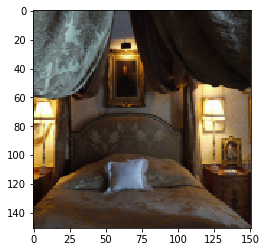

In [12]:
tp = valimg[0,:]
plt.imshow(auglist[0].augment_image(tp))

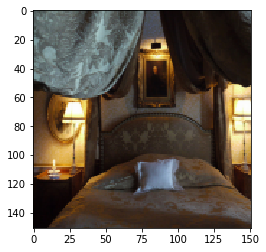

In [13]:
plt.imshow(auglist[1].augment_image(tp))

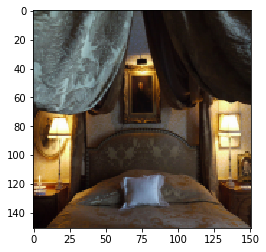

In [14]:
plt.imshow(auglist[2].augment_image(tp))

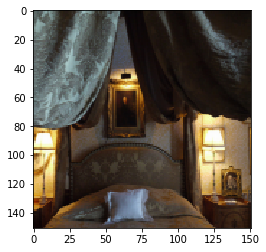

In [15]:
plt.imshow(auglist[3].augment_image(tp))

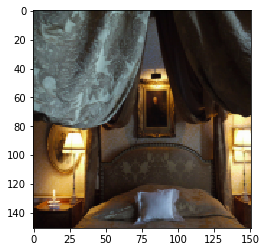

In [16]:
plt.imshow(auglist[4].augment_image(tp))

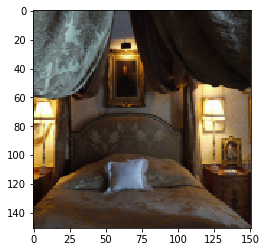

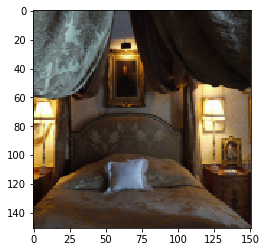

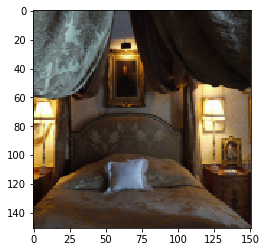

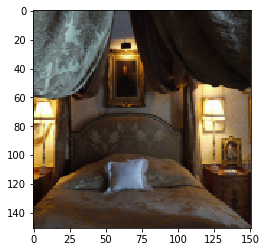

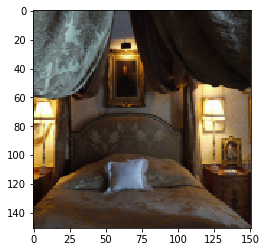

In [20]:
n=0
batch_val = 796 
nval = valimg.shape[0]
batch_vx = valimg[n*batch_val:min((n+1)*batch_val, nval-1), :]
for i in range(5):
    batch_vx = np.array(auglist[i].augment_images(batch_vx))
    plt.imshow(batch_vx[0,:])
    plt.show()

In [12]:
best_epoch = 134
batch_val = 796 
nval = valimg.shape[0]
tot_acc = 0.
auglist = [c0, c2, c4, c6, c8]
valimg = np.reshape(valimg,[-1,172,172,3])
restorename = savedir + "net-" + str(best_epoch) + ".cpkt"
print("Loading [%s]" % (restorename))
saver.restore(sess, restorename)
for i in range(4):
    avg_acc = 0.
    avg_loss = 0.
    batch_vx = valimg[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vy = vallabel[i*batch_val:min((i+1)*batch_val, nval-1), :]
    for a in range(5):
        batch_vx = np.array(auglist[a].augment_images(batch_vx))
        feeds = {x: batch_vx, y: batch_vy, is_training:False}    
        val_acc = sess.run(accr, feed_dict=feeds)
        val_loss = sess.run(cost, feed_dict=feeds)
        avg_loss += val_loss
        avg_acc += val_acc
        plt.imshow(batch_vx[0,:])
        plt.show()
        print("val accuracy: %.5f cost %.9f" % (val_acc, val_loss))
    avg_acc = avg_acc / 5.
    avg_loss = avg_loss / 5.
    print("batch [%d] val accuracy: %.5f cost %.9f" % (i, avg_acc, avg_loss))
    tot_acc += avg_acc
tot_acc = tot_acc / 4.
print("\n total avg acc : %.5f" % (tot_acc))

Loading [/users/jmy/data/nets/191_class/ggl28/net-134.cpkt]
INFO:tensorflow:Restoring parameters from /users/jmy/data/nets/191_class/ggl28/net-134.cpkt
val accuracy: 0.92462 cost 0.355383515
val accuracy: 0.92462 cost 0.355383515
val accuracy: 0.92462 cost 0.355383515
val accuracy: 0.92462 cost 0.355383515
val accuracy: 0.92462 cost 0.355383515
batch [0] val accuracy: 0.92462 cost 0.355383515
val accuracy: 0.77387 cost 1.166151762
val accuracy: 0.77387 cost 1.166151762
val accuracy: 0.77387 cost 1.166151762
val accuracy: 0.77387 cost 1.166151762
val accuracy: 0.77387 cost 1.166151762
batch [1] val accuracy: 0.77387 cost 1.166151762
val accuracy: 0.75754 cost 1.206987381
val accuracy: 0.75754 cost 1.206987381
val accuracy: 0.75754 cost 1.206987500
val accuracy: 0.75754 cost 1.206987500
val accuracy: 0.75754 cost 1.206987381
batch [2] val accuracy: 0.75754 cost 1.206987429
val accuracy: 0.74559 cost 1.196901917
val accuracy: 0.74559 cost 1.196901917
val accuracy: 0.74559 cost 1.196901917

In [22]:
best_epoch = 139
batch_val = 796 
nval = valimg.shape[0]
tot_acc = 0.
auglist = [c0, c2, c4, c6, c8]
valimg = np.reshape(valimg,[-1,172,172,3])
restorename = savedir + "net-" + str(best_epoch) + ".cpkt"
print("Loading [%s]" % (restorename))
saver.restore(sess, restorename)
for i in range(4):
    avg_acc = 0.
    avg_loss = 0.
    batch_vx = valimg[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vy = vallabel[i*batch_val:min((i+1)*batch_val, nval-1), :]
    for a in range(5):
        batch_vx = np.array(auglist[a].augment_images(batch_vx))
        feeds = {x: batch_vx, y: batch_vy, is_training:False}    
        val_acc = sess.run(accr, feed_dict=feeds)
        val_loss = sess.run(cost, feed_dict=feeds)
        avg_loss += val_loss
        avg_acc += val_acc
        print("val accuracy: %.5f cost %.9f" % (val_acc, val_loss))
    avg_acc = avg_acc / 5.
    avg_loss = avg_loss / 5.
    print("batch [%d] val accuracy: %.5f cost %.9f" % (i, avg_acc, avg_loss))
    tot_acc += avg_acc
tot_acc = tot_acc / 4.
print("\n total avg acc : %.5f" % (tot_acc))

Loading [/users/jmy/data/nets/191_class/ggl28/net-139.cpkt]
INFO:tensorflow:Restoring parameters from /users/jmy/data/nets/191_class/ggl28/net-139.cpkt
val accuracy: 0.90327 cost 0.419397950
val accuracy: 0.90327 cost 0.419397950
val accuracy: 0.90327 cost 0.419397950
val accuracy: 0.90327 cost 0.419397950
val accuracy: 0.90327 cost 0.419397950
batch [0] val accuracy: 0.90327 cost 0.419397950
val accuracy: 0.78643 cost 1.167816877
val accuracy: 0.78643 cost 1.167816877
val accuracy: 0.78643 cost 1.167816877
val accuracy: 0.78643 cost 1.167816877
val accuracy: 0.78643 cost 1.167816877
batch [1] val accuracy: 0.78643 cost 1.167816877
val accuracy: 0.75628 cost 1.248111129
val accuracy: 0.75628 cost 1.248111010
val accuracy: 0.75628 cost 1.248111010
val accuracy: 0.75628 cost 1.248111010
val accuracy: 0.75628 cost 1.248111129
batch [2] val accuracy: 0.75628 cost 1.248111057
val accuracy: 0.73804 cost 1.291738510
val accuracy: 0.73804 cost 1.291738510
val accuracy: 0.73804 cost 1.291738510

In [23]:
best_epoch = 129
batch_val = 796 
nval = valimg.shape[0]
tot_acc = 0.
auglist = [c0, c2, c4, c6, c8]
valimg = np.reshape(valimg,[-1,172,172,3])
restorename = savedir + "net-" + str(best_epoch) + ".cpkt"
print("Loading [%s]" % (restorename))
saver.restore(sess, restorename)
for i in range(4):
    avg_acc = 0.
    avg_loss = 0.
    batch_vx = valimg[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vy = vallabel[i*batch_val:min((i+1)*batch_val, nval-1), :]
    for a in range(5):
        batch_vx = np.array(auglist[a].augment_images(batch_vx))
        feeds = {x: batch_vx, y: batch_vy, is_training:False}    
        val_acc = sess.run(accr, feed_dict=feeds)
        val_loss = sess.run(cost, feed_dict=feeds)
        avg_loss += val_loss
        avg_acc += val_acc
        print("val accuracy: %.5f cost %.9f" % (val_acc, val_loss))
    avg_acc = avg_acc / 5.
    avg_loss = avg_loss / 5.
    print("batch [%d] val accuracy: %.5f cost %.9f" % (i, avg_acc, avg_loss))
    tot_acc += avg_acc
tot_acc = tot_acc / 4.
print("\n total avg acc : %.5f" % (tot_acc))

Loading [/users/jmy/data/nets/191_class/ggl28/net-129.cpkt]
INFO:tensorflow:Restoring parameters from /users/jmy/data/nets/191_class/ggl28/net-129.cpkt
val accuracy: 0.91709 cost 0.369811475
val accuracy: 0.91709 cost 0.369811475
val accuracy: 0.91709 cost 0.369811505
val accuracy: 0.91709 cost 0.369811475
val accuracy: 0.91709 cost 0.369811475
batch [0] val accuracy: 0.91709 cost 0.369811481
val accuracy: 0.78266 cost 1.182942867
val accuracy: 0.78266 cost 1.182942867
val accuracy: 0.78266 cost 1.182942867
val accuracy: 0.78266 cost 1.182942867
val accuracy: 0.78266 cost 1.182942867
batch [1] val accuracy: 0.78266 cost 1.182942867
val accuracy: 0.74874 cost 1.188341260
val accuracy: 0.74874 cost 1.188341260
val accuracy: 0.74874 cost 1.188341260
val accuracy: 0.74874 cost 1.188341260
val accuracy: 0.74874 cost 1.188341260
batch [2] val accuracy: 0.74874 cost 1.188341260
val accuracy: 0.74937 cost 1.252056718
val accuracy: 0.74937 cost 1.252056837
val accuracy: 0.74937 cost 1.252056718

In [24]:
best_epoch = 124
batch_val = 796 
nval = valimg.shape[0]
tot_acc = 0.
auglist = [c0, c2, c4, c6, c8]
valimg = np.reshape(valimg,[-1,172,172,3])
restorename = savedir + "net-" + str(best_epoch) + ".cpkt"
print("Loading [%s]" % (restorename))
saver.restore(sess, restorename)
for i in range(4):
    avg_acc = 0.
    avg_loss = 0.
    batch_vx = valimg[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vy = vallabel[i*batch_val:min((i+1)*batch_val, nval-1), :]
    for a in range(5):
        batch_vx = np.array(auglist[a].augment_images(batch_vx))
        feeds = {x: batch_vx, y: batch_vy, is_training:False}    
        val_acc = sess.run(accr, feed_dict=feeds)
        val_loss = sess.run(cost, feed_dict=feeds)
        avg_loss += val_loss
        avg_acc += val_acc
        print("val accuracy: %.5f cost %.9f" % (val_acc, val_loss))
    avg_acc = avg_acc / 5.
    avg_loss = avg_loss / 5.
    print("batch [%d] val accuracy: %.5f cost %.9f" % (i, avg_acc, avg_loss))
    tot_acc += avg_acc
tot_acc = tot_acc / 4.
print("\n total avg acc : %.5f" % (tot_acc))

Loading [/users/jmy/data/nets/191_class/ggl28/net-124.cpkt]
INFO:tensorflow:Restoring parameters from /users/jmy/data/nets/191_class/ggl28/net-124.cpkt
val accuracy: 0.91206 cost 0.350628257
val accuracy: 0.91206 cost 0.350628257
val accuracy: 0.91206 cost 0.350628257
val accuracy: 0.91206 cost 0.350628257
val accuracy: 0.91206 cost 0.350628257
batch [0] val accuracy: 0.91206 cost 0.350628257
val accuracy: 0.79146 cost 1.126006722
val accuracy: 0.79146 cost 1.126006722
val accuracy: 0.79146 cost 1.126006722
val accuracy: 0.79146 cost 1.126006722
val accuracy: 0.79146 cost 1.126006722
batch [1] val accuracy: 0.79146 cost 1.126006722
val accuracy: 0.75503 cost 1.124335885
val accuracy: 0.75503 cost 1.124335766
val accuracy: 0.75503 cost 1.124335766
val accuracy: 0.75503 cost 1.124335766
val accuracy: 0.75503 cost 1.124335766
batch [2] val accuracy: 0.75503 cost 1.124335790
val accuracy: 0.74055 cost 1.223250031
val accuracy: 0.74055 cost 1.223250031
val accuracy: 0.74055 cost 1.223250031

In [25]:
best_epoch = 119
batch_val = 796 
nval = valimg.shape[0]
tot_acc = 0.
auglist = [c0, c2, c4, c6, c8]
valimg = np.reshape(valimg,[-1,172,172,3])
restorename = savedir + "net-" + str(best_epoch) + ".cpkt"
print("Loading [%s]" % (restorename))
saver.restore(sess, restorename)
for i in range(4):
    avg_acc = 0.
    avg_loss = 0.
    batch_vx = valimg[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vy = vallabel[i*batch_val:min((i+1)*batch_val, nval-1), :]
    for a in range(5):
        batch_vx = np.array(auglist[a].augment_images(batch_vx))
        feeds = {x: batch_vx, y: batch_vy, is_training:False}    
        val_acc = sess.run(accr, feed_dict=feeds)
        val_loss = sess.run(cost, feed_dict=feeds)
        avg_loss += val_loss
        avg_acc += val_acc
        print("val accuracy: %.5f cost %.9f" % (val_acc, val_loss))
    avg_acc = avg_acc / 5.
    avg_loss = avg_loss / 5.
    print("batch [%d] val accuracy: %.5f cost %.9f" % (i, avg_acc, avg_loss))
    tot_acc += avg_acc
tot_acc = tot_acc / 4.
print("\n total avg acc : %.5f" % (tot_acc))

Loading [/users/jmy/data/nets/191_class/ggl28/net-119.cpkt]
INFO:tensorflow:Restoring parameters from /users/jmy/data/nets/191_class/ggl28/net-119.cpkt
val accuracy: 0.91332 cost 0.357754350
val accuracy: 0.91332 cost 0.357754320
val accuracy: 0.91332 cost 0.357754350
val accuracy: 0.91332 cost 0.357754320
val accuracy: 0.91332 cost 0.357754320
batch [0] val accuracy: 0.91332 cost 0.357754332
val accuracy: 0.79523 cost 1.094689727
val accuracy: 0.79523 cost 1.094689727
val accuracy: 0.79523 cost 1.094689727
val accuracy: 0.79523 cost 1.094689727
val accuracy: 0.79523 cost 1.094689727
batch [1] val accuracy: 0.79523 cost 1.094689727
val accuracy: 0.73618 cost 1.239063740
val accuracy: 0.73618 cost 1.239063740
val accuracy: 0.73618 cost 1.239063740
val accuracy: 0.73618 cost 1.239063740
val accuracy: 0.73618 cost 1.239063740
batch [2] val accuracy: 0.73618 cost 1.239063740
val accuracy: 0.74181 cost 1.263903856
val accuracy: 0.74181 cost 1.263903737
val accuracy: 0.74181 cost 1.263903737

In [26]:
best_epoch = 114
batch_val = 796 
nval = valimg.shape[0]
tot_acc = 0.
auglist = [c0, c2, c4, c6, c8]
valimg = np.reshape(valimg,[-1,172,172,3])
restorename = savedir + "net-" + str(best_epoch) + ".cpkt"
print("Loading [%s]" % (restorename))
saver.restore(sess, restorename)
for i in range(4):
    avg_acc = 0.
    avg_loss = 0.
    batch_vx = valimg[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vy = vallabel[i*batch_val:min((i+1)*batch_val, nval-1), :]
    for a in range(5):
        batch_vx = np.array(auglist[a].augment_images(batch_vx))
        feeds = {x: batch_vx, y: batch_vy, is_training:False}    
        val_acc = sess.run(accr, feed_dict=feeds)
        val_loss = sess.run(cost, feed_dict=feeds)
        avg_loss += val_loss
        avg_acc += val_acc
        print("val accuracy: %.5f cost %.9f" % (val_acc, val_loss))
    avg_acc = avg_acc / 5.
    avg_loss = avg_loss / 5.
    print("batch [%d] val accuracy: %.5f cost %.9f" % (i, avg_acc, avg_loss))
    tot_acc += avg_acc
tot_acc = tot_acc / 4.
print("\n total avg acc : %.5f" % (tot_acc))

Loading [/users/jmy/data/nets/191_class/ggl28/net-114.cpkt]
INFO:tensorflow:Restoring parameters from /users/jmy/data/nets/191_class/ggl28/net-114.cpkt
val accuracy: 0.91960 cost 0.340550572
val accuracy: 0.91960 cost 0.340550572
val accuracy: 0.91960 cost 0.340550572
val accuracy: 0.91960 cost 0.340550572
val accuracy: 0.91960 cost 0.340550572
batch [0] val accuracy: 0.91960 cost 0.340550572
val accuracy: 0.77889 cost 1.127307177
val accuracy: 0.77889 cost 1.127307177
val accuracy: 0.77889 cost 1.127307177
val accuracy: 0.77889 cost 1.127307177
val accuracy: 0.77889 cost 1.127307177
batch [1] val accuracy: 0.77889 cost 1.127307177
val accuracy: 0.74121 cost 1.179367065
val accuracy: 0.74121 cost 1.179367065
val accuracy: 0.74121 cost 1.179367065
val accuracy: 0.74121 cost 1.179367065
val accuracy: 0.74121 cost 1.179367065
batch [2] val accuracy: 0.74121 cost 1.179367065
val accuracy: 0.72796 cost 1.216242552
val accuracy: 0.72796 cost 1.216242552
val accuracy: 0.72796 cost 1.216242552

In [27]:
best_epoch = 99
batch_val = 796 
nval = valimg.shape[0]
tot_acc = 0.
auglist = [c0, c2, c4, c6, c8]
valimg = np.reshape(valimg,[-1,172,172,3])
restorename = savedir + "net-" + str(best_epoch) + ".cpkt"
print("Loading [%s]" % (restorename))
saver.restore(sess, restorename)
for i in range(4):
    avg_acc = 0.
    avg_loss = 0.
    batch_vx = valimg[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vy = vallabel[i*batch_val:min((i+1)*batch_val, nval-1), :]
    for a in range(5):
        batch_vx = np.array(auglist[a].augment_images(batch_vx))
        feeds = {x: batch_vx, y: batch_vy, is_training:False}    
        val_acc = sess.run(accr, feed_dict=feeds)
        val_loss = sess.run(cost, feed_dict=feeds)
        avg_loss += val_loss
        avg_acc += val_acc
        print("val accuracy: %.5f cost %.9f" % (val_acc, val_loss))
    avg_acc = avg_acc / 5.
    avg_loss = avg_loss / 5.
    print("batch [%d] val accuracy: %.5f cost %.9f" % (i, avg_acc, avg_loss))
    tot_acc += avg_acc
tot_acc = tot_acc / 4.
print("\n total avg acc : %.5f" % (tot_acc))

Loading [/users/jmy/data/nets/191_class/ggl28/net-99.cpkt]
INFO:tensorflow:Restoring parameters from /users/jmy/data/nets/191_class/ggl28/net-99.cpkt
val accuracy: 0.90829 cost 0.339504600
val accuracy: 0.90829 cost 0.339504600
val accuracy: 0.90829 cost 0.339504600
val accuracy: 0.90829 cost 0.339504600
val accuracy: 0.90829 cost 0.339504600
batch [0] val accuracy: 0.90829 cost 0.339504600
val accuracy: 0.78266 cost 1.082338691
val accuracy: 0.78266 cost 1.082338691
val accuracy: 0.78266 cost 1.082338691
val accuracy: 0.78266 cost 1.082338691
val accuracy: 0.78266 cost 1.082338691
batch [1] val accuracy: 0.78266 cost 1.082338691
val accuracy: 0.72864 cost 1.138785481
val accuracy: 0.72864 cost 1.138785481
val accuracy: 0.72864 cost 1.138785481
val accuracy: 0.72864 cost 1.138785481
val accuracy: 0.72864 cost 1.138785481
batch [2] val accuracy: 0.72864 cost 1.138785481
val accuracy: 0.74307 cost 1.145815015
val accuracy: 0.74307 cost 1.145815134
val accuracy: 0.74307 cost 1.145815253
v

In [9]:
best_epoch = 149

batch_val = 795 
nval = valimg.shape[0]
avg_acc = 0.
#valimg = np.reshape(valimg,[3160,139,139,3])
restorename = savedir + "net-" + str(best_epoch) + ".cpkt"
print("Loading [%s]" % (restorename))
saver.restore(sess, restorename)
#randpermlist = np.random.permutation(nval)
for i in range(4):
    batch_vx = valimg[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vy = vallabel[i*batch_val:min((i+1)*batch_val, nval-1), :]
    batch_vx = augment_valimg(batch_vx)
    feeds = {x: batch_vx, y: batch_vy, is_training:False}    
    val_acc = sess.run(accr, feed_dict=feeds)
    val_loss = sess.run(cost, feed_dict=feeds)
    avg_acc += val_acc
    #misid = np.where(sess.run(corr, feed_dict=feeds) == 0)[0]
    #feeds = {x : batch_vx[misid, :], y : batch_vy[misid, :], is_training:False}
    #pred_mis = sess.run(pred, feed_dict=feeds)
    #answ_mis = np.argmax(pred_mis, 1)
    #answ_corr = np.argmax(batch_vy[misid, :], 1)
    #mislblist = np.concatenate((mislblist, answ_mis))
    #corrlblist = np.concatenate((corrlblist, answ_corr))
    #totmisid = np.concatenate((totmisid, misid+1580*i))
    print("val accuracy: %.5f cost %.9f" % (val_acc, val_loss))
avg_acc = avg_acc / 3
print("\n avg acc : %.5f" % (avg_acc))

Loading [/users/jmy/data/nets/191_class/ggl28/net-149.cpkt]
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /users/jmy/data/nets/191_class/ggl28/net-149.cpkt


ResourceExhaustedError: OOM when allocating tensor with shape[1061,48,147,147] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[node conv_2b_3x3/Conv2D (defined at <ipython-input-4-b738f24e10bb>:25) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[node Mean_1 (defined at <ipython-input-6-cb66fbd9e2eb>:5) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'conv_2b_3x3/Conv2D', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-cb66fbd9e2eb>", line 1, in <module>
    aux, pred = GoogLenet(x, is_training=False)
  File "<ipython-input-4-b738f24e10bb>", line 25, in GoogLenet
    net = slim.conv2d(net, 48, [3, 3], padding='SAME', scope='conv_2b_3x3')
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1155, in convolution2d
    conv_dims=2)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/contrib/layers/python/layers/layers.py", line 1058, in convolution
    outputs = layer.apply(inputs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/base_layer.py", line 1227, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/layers/base.py", line 530, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/engine/base_layer.py", line 554, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/layers/convolutional.py", line 194, in call
    outputs = self._convolution_op(inputs, self.kernel)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_ops.py", line 966, in __call__
    return self.conv_op(inp, filter)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_ops.py", line 591, in __call__
    return self.call(inp, filter)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_ops.py", line 208, in __call__
    name=self.name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 1026, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1061,48,147,147] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[node conv_2b_3x3/Conv2D (defined at <ipython-input-4-b738f24e10bb>:25) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[node Mean_1 (defined at <ipython-input-6-cb66fbd9e2eb>:5) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
restorename = savedir + "net-" + str(best_epoch) + ".cpkt"
print("Loading [%s]" % (restorename))
saver.restore(sess, restorename)
feeds = {x: valimg, y: vallabel, is_training: False}
val_acc = sess.run(accr, feed_dict=feeds)
print("val accuracy: %.5f" % (val_acc))

----